In [40]:
from model import *
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import *
import gmaps
import gmaps.datasets

In [4]:
df_commute = pd.read_csv('data/commute_data.csv')
df_tracts = pd.read_csv('data/census_tracts_2010.csv')
df_tracts = df_tracts.rename(columns=lambda x: x.strip())

# Merge on OFIPS = GEOID (federal representation of census tract ID)
df_merged = df_commute.merge(df_tracts, how='inner', left_on='OFIPS', right_on='GEOID')
df_merged = df_merged.merge(df_tracts, how='inner', left_on='DFIPS', right_on='GEOID', suffixes = ('_O','_D'))

In [7]:
df_bayarea = limit_area(df_merged, minlat=35.959793, maxlat=38.419866, minlong=-123.355416, maxlong=-120.609292)

In [61]:
df_state = limit_area(df_merged, state='NY', maxlat=41)

In [70]:
df_nyc = limit_area(df_merged, minlat=40.5, maxlat=41, minlong=-74.25, maxlong=-73.75)

In [71]:
df_distance_matrix = create_distance_matrix(df_nyc, method='absolute')

In [72]:
linkage_method = 'complete'
Z = linkage(df_distance_matrix, linkage_method)

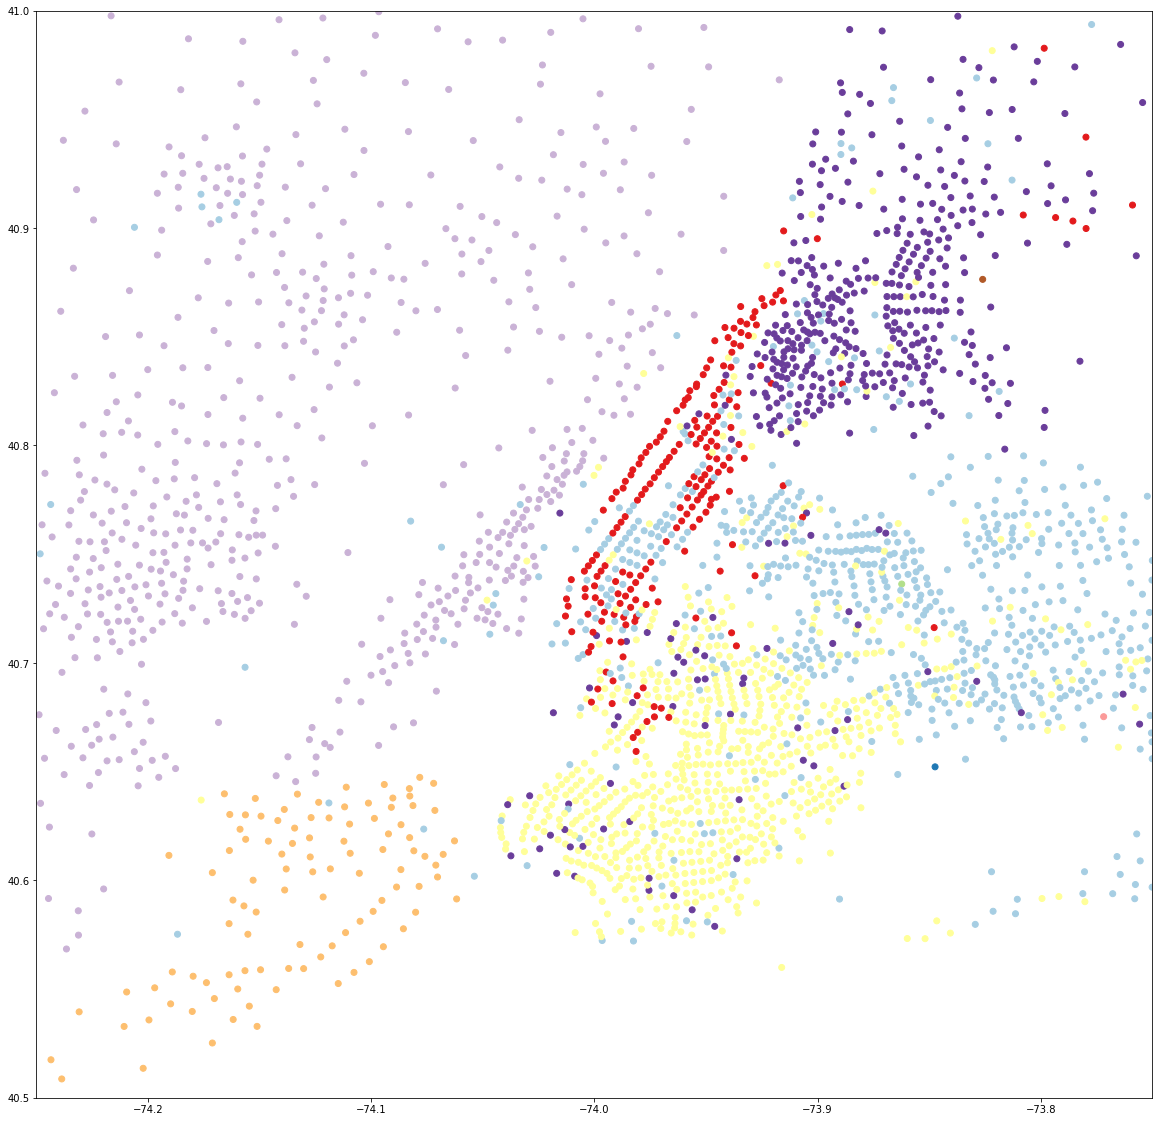

In [73]:
k = 10
df_results = pd.DataFrame(index = df_distance_matrix.columns, data=fcluster(Z,k,criterion='maxclust'))

df_results = df_results.rename(columns={0: 'cluster_id'})

df_results = df_results.merge(df_tracts, left_index=True, right_on='GEOID')

plt.figure(figsize=(20,20))
plt.scatter(df_results['INTPTLONG'],df_results['INTPTLAT'], c=df_results['cluster_id'].values, cmap='Paired')
plt.ylim(40.5,41)
plt.xlim(-74.25, -73.75)
plt.show()